# Imaging High Redshift Quasars
GOAL: do a SDSS query and look at images of high redshift quasars in MegaPipe images

> Chris Willott: the idea there is to use astroquery to select a sample of quasars from the SDSS catalog server with some particular properties and then cross-match that list against CFHT MegaPipe imaging in the i filter and get images for all the matched quasars. So if you can get a query to SDSS working first and then do the cross-match of a few quasar positions to get some with CFHT imaging we can fine tune the exact criteria and “science goal” later on. There is a CAS jobs AGN/quasar catalog that can be queried described at https://www.sdss.org/dr14/data_access/value-added-catalogs/?vac_id=optical-emission-line-properties-and-black-hole-mass-estimates-for-spiders-dr14-agn

SPectroscopic IDentfication of ERosita Sources (SPIDERS) https://www.sdss.org/surveys/eboss/#spiders
 
his page explains how to access DR14 data, and provides links to various data access tools: https://www.sdss.org/dr14/data_access/

In this notebook, we will image quasars with a high redshift. To find the quasars, we will query SDSS Value Addded Catalog (VAC) that contains a list of quasars and their properties, then select some that fit our requirements. Then we will query CADC data for the 


To fetch data, we will use the CADC package of astroquery, which queries data provided by the [Canadian Astronomical Data Centre](http://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca ). This tutorial will end-to-end from querying to displaying an image.

## Table of Contents
* [1. Introduction](#Introduction)
* [2. Setup](#Setup)
* [3. Querying](#Querying)
* [4. Fetching Data](#Fetching-Data)
* [5. Ploting Results](#Ploting-Results)

## Introduction
Info about
* SDSS
* MegaPipe
* Quasars


## Setup
This tutorial will go through some of the basic functionalities of the CADC astroquery package. The CADC module can be installed using the command:

```
pip install --pre astroquery
```

(The `--pre` tag installs the pre-release version which we need because the CADC package is not in the latest release.) Alternatively, you can clone and install from the source:

```
# If you have a github account:
git clone git@github.com:astropy/astroquery.git
# If you do not:
git clone https://github.com/astropy/astroquery.git
cd astroquery
python setup.py install
```
Note that these commands can also be done in a jupyter notebook by either declaring the code cell a bash cell by pasting `%%bash` at the top of the cell, or preceding each line with a `!`.
More information about astroquery can be found at the [astroquery github repository](https://github.com/astropy/astroquery).

Now, onto the tutorial!

## Querying

### Find suitable target
For this tutorial, we want to look at high redshift quasars. We will use the SDSS surve to collect suitable quasars


To find a suitable quasar, we can look at the [SPIDERS DR14 AGN
VAC](https://www.sdss.org/dr14/data_access/value-added-catalogs/?vac_id=optical-emission-line-properties-and-black-hole-mass-estimates-for-spiders-dr14-agn). Looking through the [SDSS Data Model](https://data.sdss.org/datamodel/files/SPIDERS_ANALYSIS/) the best catalog for ors needs looks like the `spiders_quasar_bhmass` file. The access url is `https://data.sdss.org/sas/dr14/eboss/spiders/analysis/spiders_quasar_bhmass-DR14.fits`, which we can stream and then filter. The columns are all described at the [spiders_quasar_bhmass data model page](https://data.sdss.org/datamodel/files/SPIDERS_ANALYSIS/spiders_quasar_bhmass.html). Right now, lets select rows with `redshift` > 2.0.


In [69]:
# Need to get the fits 1st exetention, file (stream), then do our query
from astropy.table import Table

#fname = 'data/spiders_quasar_bhmass-DR14.fits' # If url takes too long
url = 'https://data.sdss.org/sas/dr14/eboss/spiders/analysis/spiders_quasar_bhmass-DR14.fits'
important_cols = ['xray_detection', 'name', 'RA', 'DEC', 'plate', 'redshift']

# Grab the data from the url and convert to a pandas dataframe
qso_table = Table.read(url, format='fits')
qso_data = qso_table.to_pandas()

# Filter and sort the data on redshift value
high_redshift_qso_data = qso_data[qso_data['redshift']  > 2.0].sort_values(by=['redshift'], ascending=False)
high_redshift_qso_data[important_cols][0:10]


,xray_detection,name,RA,DEC,plate,redshift
1030,b'2RXS ',b'2RXS J143417.1+333047 ',218.57156,33.51318,3860,2.485000
1029,b'2RXS ',b'2RXS J132016.5+095337 ',200.06911,9.89388,5426,2.477000
1722,b'2RXS ',b'2RXS J142924.3+465245 ',217.35145,46.87933,8434,2.475982
1028,b'2RXS ',b'2RXS J141049.1+461643 ',212.70485,46.27886,6751,2.462000
1027,b'2RXS ',b'2RXS J161603.5+302359 ',244.01489,30.39989,4956,2.460000
1026,b'2RXS ',b'2RXS J085218.2+473455 ',133.07604,47.58214,5161,2.415342
1025,b'2RXS ',b'2RXS J143853.0+371049 ',219.72117,37.18041,4714,2.400000
1024,b'2RXS ',b'2RXS J100516.6+480545 ',151.31920,48.09589,6661,2.390000
1023,b'2RXS ',b'2RXS J133148.8+303145 ',202.95374,30.52929,6492,2.380000
1721,b'2RXS ',b'2RXS J012642.9+255901 ',21.67909,25.98366,7685,2.368770


Now we have a list of suitable quasars! Yay! Now, in order to query the CADC data, we are going to extract the coordinates and search for all `CFHTMEGAPIPE` data collections in those coordinates.

In [86]:
from astropy.coordinates import SkyCoord

name_list = high_redshift_qso_data['name'].values
coords_from_name = [SkyCoord.from_name(str(qso_name), parse=True) for qso_name in name_list]


In [88]:
# Try both coords from name and from ra dec fields and see which one is better
ra_list = high_redshift_qso_data['RA'].values
dec_list = high_redshift_qso_data['DEC'].values
coords_from_ra_dec_fields = [SkyCoord(ra, dec, frame='icrs', unit='deg') for ra, dec in zip(ra_list, dec_list)]


### Query Method 1: `query_region` function
The simplest way to query data by target name is to use the `query_name` function. It takes a string and [returns all the results that contain the string in the `target name` field](https://github.com/astropy/astroquery/blob/master/astroquery/cadc/core.py#L205-L208). After querying, we can further filter down the results using boolean masks on the data. In order to filter the data, we need to see which columns are in the results, and also what data type they are. So lets first do the query and then print the resulting columns and their descriptions.

In [89]:
from astropy.table import vstack
from astroquery.cadc import Cadc
cadc = Cadc()

#results_list = [cadc.query_region(coords, collection='CFHTMEGAPIPE') for coords in coords_from_name]
# coords_results_list = list(zip(coords_from_name, results_list))
# print(coords_results_list)

results_list = []
name_list = high_redshift_qso_data['name'].values
for target_name, coords in zip(name_list, coords_from_ra_dec_fields): # TODO: try with coords from field too
    results = cadc.query_region(coords, collection='CFHTMEGAPIPE')
    if len(results):
        # We add target coordinates as columns to later make cutout process easier
        results['qso_target_name'] = target_name
        results['qso_target_ra'] = coords.ra
        results['qso_target_dec'] = coords.dec
        results_list.append(results)
    
# Maybe add a column to the table with target coordinates?? For better imaging???
# ^ I like adding the column idea > better for when we stack the table
# Could also do a dict with target_name, target_coords, results_table??
#results = vstack(results_list)
#results.show_in_notebook()

results = vstack(results_list)  


Looking through the columns, we want results that have the i filter (https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/en/megapipe/docs/filt.html). So either I.MP9701, I.MP9702, or I.MP9703 for `energy_bandpssName`, also `dataProductType` of type 'image'. Once we filter the results, we will display a subset of the columns (since there are so many!) using the astropy table `show_in_notebook` method.


In [90]:
# Construct the filter
results_filter = ([energy_bandpass_name.startswith('i.') for energy_bandpass_name in 
                   results['energy_bandpassName']]) &\
                 (results['dataProductType'] == 'image')

# Apply the filter to the results
filtered_results = results[results_filter]

print('Number of results pre-filter: {}'.format(len(results)))
print('Number of results post-filter: {}'.format(len(filtered_results)))

columns_subset = ['productID', 'collection', 'observationID', 'energy_bandpassName', \
                  'target_name', 'qso_target_name', 'qso_target_ra', 'qso_target_dec', \
                   'telescope_name', 'instrument_name', 'dataProductType']

filtered_results[columns_subset].show_in_notebook()


Number of results pre-filter: 142
Number of results post-filter: 20


idx,productID,collection,observationID,energy_bandpassName,target_name,qso_target_name,qso_target_ra,qso_target_dec,telescope_name,instrument_name,dataProductType
,,,,,,,deg,deg,,,
0,MegaPipe.210.262.I.MP9702,CFHTMEGAPIPE,MegaPipe.210.262,i.MP9702,M0913,2RXS J091547.5+410310,138.94799,41.05278,CFHT 3.6m,MegaPrime,image
1,G025.138.432+40.928.I3,CFHTMEGAPIPE,G025.138.432+40.928,i.MP9703,M0913,2RXS J091547.5+410310,138.94799,41.05278,CFHT 3.6m,MegaPrime,image
2,G018.186.615+31.342.I,CFHTMEGAPIPE,G018.186.615+31.342,i.MP9701,NGC 4414,2RXS J122824.0+312817,187.10036,31.4716,CFHT 3.6m,MegaPrime,image
3,G018.186.660+31.865.I,CFHTMEGAPIPE,G018.186.660+31.865,i.MP9701,NGC 4414 OFF,2RXS J122824.0+312817,187.10036,31.4716,CFHT 3.6m,MegaPrime,image
4,MegaPipe.319.243.I.MP9701,CFHTMEGAPIPE,MegaPipe.319.243,i.MP9701,F08746_1,2RXS J122824.0+312817,187.10036,31.4716,CFHT 3.6m,MegaPrime,image
5,MegaPipe.319.243.I.MP9702,CFHTMEGAPIPE,MegaPipe.319.243,i.MP9702,F08746_1,2RXS J122824.0+312817,187.10036,31.4716,CFHT 3.6m,MegaPrime,image
6,MegaPipe.413.208.I.MP9701,CFHTMEGAPIPE,MegaPipe.413.208,i.MP9701,CPAPIR-307,2RXS J141030.0+135942,212.62527,13.99505,CFHT 3.6m,MegaPrime,image
7,MegaPipe.321.236.I.MP9702,CFHTMEGAPIPE,MegaPipe.321.236,i.MP9702,NGVS_BG_2,2RXS J120728.2+275509,181.86788,27.91939,CFHT 3.6m,MegaPrime,image
8,MegaPipe.057.166.I.MP9701,CFHTMEGAPIPE,MegaPipe.057.166,i.MP9701,A0274,2RXS J015351.0-065648,28.46275,-6.94692,CFHT 3.6m,MegaPrime,image


### Query Method 2: ADQL
The second method is to bundle the query and filtering in one using Astronomical Data Query Language, or ADQL. In this case, we will do both the querying and the filtering in one step.

In [ ]:
# query_vars = { 'object_name': object_name, 'lower': lower_bound_m, 'upper': upper_bound_m}

# query = '''SELECT *
# FROM caom2.Plane AS Plane 
# JOIN caom2.Observation AS Observation ON Plane.obsID = Observation.obsID 
# WHERE ( ( Observation.target_name LIKE '%{object_name}%' )
# AND ( Plane.energy_bandpassName LIKE 'r.%' OR Plane.energy_bandpassName LIKE 'i.%' )
# AND ( INTERSECTS( CIRCLE('ICRS',
# {ra},
# {dec},
# {radius}),
# Plane.position_bounds ) = 1 )
# AND ( Plane.energy_bounds_lower >= {lower} )
# AND ( Plane.energy_bounds_upper <= {upper} ) 
# AND ( Plane.dataProductType = 'image'))'''.format(**query_vars)

# job = cadc.run_query(query, 'sync')
# results = job.get_results()

# results[columns_subset].show_in_notebook()

Notice how we have the same number of results using both the two methods? Pretty  neat :)

## Fetching Data
Now let's choose two images, find a suitable cutout, download them, and display them. We will use the `get_data_urls` function to actually access the data.

In [91]:
urls = cadc.get_data_urls(filtered_results)
filtered_results['url'] = urls

The stucture of the url's can be broken into a few parts. Take `https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/GEMINI/N20050108S0186.fits.gz?RUNID=tv7rbo39ibkh7726` as an example...
- `https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/`: This is the service url. The 'data/pub' ending accesses all public files. For files the requires authorization, there will be a redirect to 'data/auth' which require authorization
- `GEMINI`: This is the archive name.
- `N20050108S0186.fits.gz`: This is the file name.
- `RUNID=tv7rbo39ibkh7726`: TODO: Get a good definition for this!! These are additional query parameters. I don't exactly know what this means!

The urls give access to the actual data, so now we can fetch the file, get data to calculate a cutout, open it with the astropy fits module, and display an image!


### Calculating cutouts

One thing to note is that the data products probably contain much more information than we actually need. In order to reduce the amount of data and total processing time, we can request cutouts of the fits files that only contain the slice of information that we want. In order to do a cutout, we need the range of pixels we want, and/or the fits extensions that we want. In this particular case, we want to compare the same area on multiple different files, so we want to do a cutout based on the coordinates we want to look at. In order to do this, we will grab the ICRA coordinates of the [05D2ah](http://simbad.u-strasbg.fr/simbad/sim-basic?Ident=snls05D2ah&submit=SIMBAD+search) object ( which are 10h01m28.728s +01d51m45.83s) and recruit the `cadccutout` package which can transform coordinates to the pixel range used to perform the cutout.


In [92]:
from cadccutout import Transform
from astropy.io import fits
from astropy.coordinates import SkyCoord

def cutout_pixels_from_position_with_ext(cutout_position, url, ext=0):
    transform = Transform()
    to_cutout_string = lambda pix_range: '[{}][{}:{},{}:{}]'.format(ext, pix_range[0][0], 
                                                                    pix_range[0][1], 
                                                                    pix_range[1][0], 
                                                                    pix_range[1][1])
    try:
        header = fits.getheader(url, ext)
        hdu_pixels = transform.world_to_pixels([cutout_position], header)
        pix_range = hdu_pixels.get_ranges()
        if pix_range[0][0] >= pix_range[0][1] or pix_range[1][0] >= pix_range[1][1]:
            return False
        return to_cutout_string(pix_range)
    except TypeError:
        return (cutout_pixels_from_position_with_ext(cutout_position, url, ext=ext+1) if
                ext==0 else False)

def cutout_pixels_from_position(cutout_position, url, ext=0):
    transform = Transform()
    to_cutout_string = lambda pix_range: '[{}:{},{}:{}]'.format(pix_range[0][0], 
                                                                pix_range[0][1], 
                                                                pix_range[1][0], 
                                                                pix_range[1][1])
    try:
        header = fits.getheader(url, ext)
        hdu_pixels = transform.world_to_pixels([cutout_position], header)
        pix_range = hdu_pixels.get_ranges()
        if pix_range[0][0] >= pix_range[0][1] or pix_range[1][0] >= pix_range[1][1]:
            return False
        return to_cutout_string(pix_range)
    except TypeError:
        return (cutout_pixels_from_position(cutout_position, url, ext=ext+1) if 
                ext==0 else False)
    
# TODO: Figure out how to extract coordinates?
cutout_region_string = lambda ra, dec, radius: 'CIRCLE {ra} {dec} {radius}'.format(ra=ra, dec=dec, radius=radius)



In [93]:
cutouts = [cutout_pixels_from_position_with_ext(cutout_region_string(ra, dec, 0.005), url) for (url, ra, dec) in
           zip(filtered_results['url'], filtered_results['qso_target_ra'], 
               filtered_results['qso_target_dec'])]

filtered_results['qso_url_cutout'] = cutouts

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


In [94]:
# Filter out results with an invalid cutout
# urls_cutouts = list(filter(lambda x: x[0], zip(cutouts, filtered_results)))
# urls_cutouts

filtered_results_good_cutouts = filtered_results[(filtered_results['qso_url_cutout'] != 'False')]

### Retriving Data with Requests
With the cutout values, we can now download the data. There are many different methods to perform a cutout, but today we will add the cutout string to the parameter in the request. More information about requesting CADC data can be found [in the documentation](http://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/en/doc/data/).


In [95]:
import re
import requests
from astropy.wcs import WCS

#TODO: Make this read file if already there
#TODO: Catch 400 errors
def download_url_to_file(url, cutout=None, data_dir='data'):
    '''Takes a url, downloads the resource, saves it in the data directory with the name 
    specified in the response Content Disposition, and returns the file path and name'''

    def get_filename_from_response(response):
        content_disposition = response.headers['Content-Disposition']
        return re.findall("filename=(.+)", content_disposition)[0]

    resp = requests.get(url, params={'cutout': cutout}) if cutout else requests.get(url)
    fname = get_filename_from_response(resp)
    file_name_and_path = '{data_dir}/{fname}'.format(data_dir=data_dir, fname=fname)
    # Note: wb will overwrite if something is already there
    with open(file_name_and_path, 'wb') as f:
        f.write(resp.content)
        
    return file_name_and_path

def get_image_data(file, ext=0):
    '''Returns the image data and wcs coordinate data of a fits file at the 
    given extension'''
    with fits.open(file, ignore_missing_end=True) as hdulist:
        hdulist.info()
        w = WCS(hdulist[ext].header)
        image_data = hdulist[ext].data
    return image_data, w

def get_image_data_from_url(url, cutout=None, ext=0):
    '''Returns the image data and wcs coordinate data of a fits file at the 
    given extension'''
    data_url = url + '&cutout={}'.format(cutout) if cutout else url
    with fits.open(data_url, ignore_missing_end=True) as hdulist:
        hdulist.info()
        w = WCS(hdulist[ext].header)
        image_data = hdulist[ext].data
    return image_data, w

# To save to a file then read to image data
#fname_list = [download_url_to_file(url, cutout=cutout) for url, cutout 
#              in zip(urls, cutouts)]
#data_list = [get_image_data(fname) for fname in fname_list]

# To stream from urls
data_list = [(*get_image_data_from_url(result['url'], cutout=result['qso_url_cutout']), 
              result['qso_target_name'], result['qso_target_ra'], result['qso_target_dec']) 
             for result in filtered_results_good_cutouts]
# TODO: Make this a dict? 


Filename: /home/badune/.astropy/cache/download/py3/d58f809f58efb1f0bd5153ba403639ba
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      56   (196, 195)   float32   


Filename: /home/badune/.astropy/cache/download/py3/6066ac959e3c277f9d37ddc7486e5731
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      76   (196, 196)   float32   


Filename: /home/badune/.astropy/cache/download/py3/da22848f4b40aaa0e2bd2bed51afe65e
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      73   (195, 195)   float32   


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


Filename: /home/badune/.astropy/cache/download/py3/ee16bfa7cad1d3d48f753e23a0fe1252
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      73   (195, 196)   float32   
Filename: /home/badune/.astropy/cache/download/py3/4d415f6af62f9b20dde252a04e9c6475
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      67   (196, 196)   float32   


Filename: /home/badune/.astropy/cache/download/py3/eb615226e5723b6f44993e804aaeca6f
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      57   (196, 196)   float32   


Filename: /home/badune/.astropy/cache/download/py3/c1daddcd7f0430157c1b1e2dd7a0abcc
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      56   (196, 196)   float32   


Filename: /home/badune/.astropy/cache/download/py3/e1c2941a5330bbf4c78c5030e210ec35
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      58   (196, 195)   float32   


Filename: /home/badune/.astropy/cache/download/py3/00896504e6f78700d2d160e140950159
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      61   (196, 196)   float32   


Filename: /home/badune/.astropy/cache/download/py3/593da22c80c0b226709bde7461b8cf48
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      56   (195, 195)   float32   


Filename: /home/badune/.astropy/cache/download/py3/a842183f7887966df6fefb0579582737
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      59   (196, 196)   float32   


Filename: /home/badune/.astropy/cache/download/py3/6b39dfff15c68331ab19c97c8e146bb2
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      62   (196, 196)   float32   


Filename: /home/badune/.astropy/cache/download/py3/f488068438b3a7113862075f2ee9c09f
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      58   (196, 196)   float32   


Filename: /home/badune/.astropy/cache/download/py3/118021c7a4cff9d3c2a8a12b454cfb0e
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      73   (196, 196)   float32   
Filename: /home/badune/.astropy/cache/download/py3/f993359acfb08d7e3d63c68a3d11d59e
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      73   (196, 196)   float32   
Filename: /home/badune/.astropy/cache/download/py3/aa48a1d608d827ecdde14e2a47b3b2fb
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      57   (196, 196)   float32   


Filename: /home/badune/.astropy/cache/download/py3/29dcafd9869c25a57b5682e3a6148104
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      60   (196, 196)   float32   


Filename: /home/badune/.astropy/cache/download/py3/643cf27a7b1c0ec2d05b277db344bde4
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      66   (195, 196)   float32   


Filename: /home/badune/.astropy/cache/download/py3/98fee2798a2fc79ed80624d9eb14f6f5
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      60   (196, 196)   float32   


## Ploting Results

Now that we have the image data and the coordinate data of all our cutouts, we can begin to plot the data!

In [51]:
def print_image_list_stats(data_list):
    for idx, (image_data, w, name) in enumerate(data_list):
        print("IMAGE {} STATS".format(idx))
        nonzero = np.count_nonzero(image_data)
        total = image_data.size
        print('Percent Nonzero: {}'.format(nonzero/total))
        stats = {'min': np.nanmin(image_data), 'max': np.nanmax(image_data), 
                 'mean': np.nanmean(image_data), 'std': np.nanstd(image_data)}
        print('Min: {min} \nMax: {max} \nMean: {mean}\nStdev: {std}'.format(**stats))
    
#print_image_list_stats(data_list)

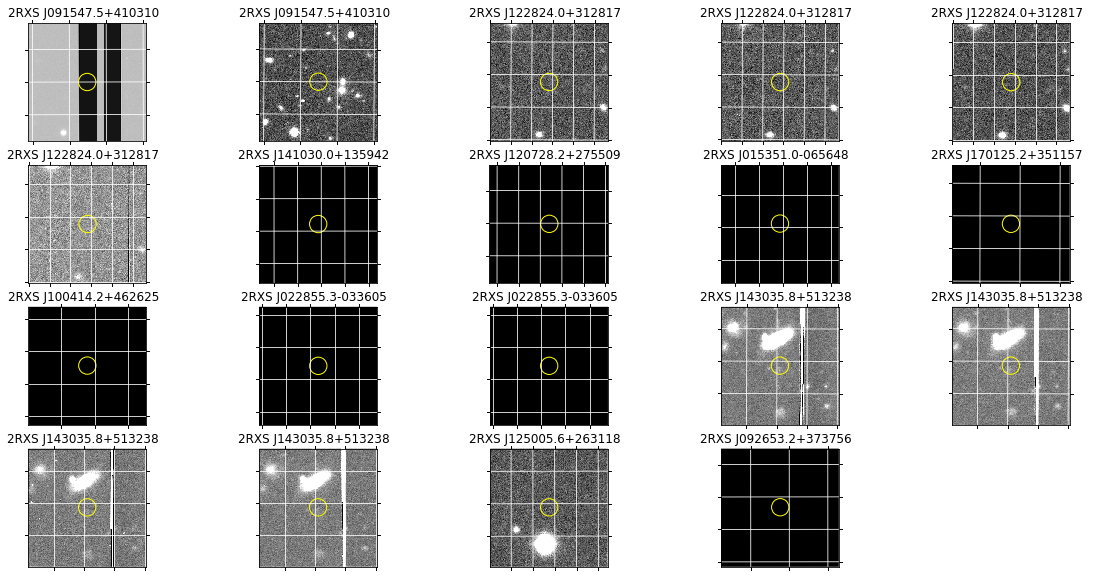

In [96]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from astropy.visualization import (LinearStretch, ImageNormalize, PercentileInterval, 
                                   MinMaxInterval, ZScaleInterval)

np.seterr(divide='ignore', invalid='ignore')
#TODO: Add lables and titles!
#TODO: look and see how to make imshow better
#TODO: Add circles around targets
def plot_image_list(data_list, geo=None):

    if geo is None:
        geo = (len(data_list), 1) #nrows, ncols
        
    fig = plt.figure(figsize=(20,10))
    for idx, (image_data, wcs, qso_target_name, qso_target_ra, qso_target_dec) in enumerate(data_list):
        
        ax = plt.subplot(geo[0], geo[1], idx+1, projection=wcs)

        ax.scatter(qso_target_ra, qso_target_dec, transform=ax.get_transform('icrs'), s=300,
           edgecolor='yellow', facecolor='none')
        image_data_norm = ImageNormalize(image_data, interval=ZScaleInterval(), 
                                         stretch=LinearStretch())
        ax.imshow(image_data, norm=image_data_norm, cmap='gray')
        ax.set_title(qso_target_name)
        
        ax.coords.grid(color='white', ls='solid')
        ra, dec = ax.coords['ra'], ax.coords['dec']
        ra.set_ticklabel_visible(False)
        dec.set_ticklabel_visible(False)
        ra.set_axislabel('')
        dec.set_axislabel('')

# Should I split up into groups of objects we are trying to image???
plot_image_list(data_list, geo=(4, 5))

In [ ]:
def plot_image_list_same_axes(data_list, geo=None): # Should only really do this for same qso_target_name
    if geo is None:
        geo = (1, len(data_list)) #nrows, ncols
        
    wcs_trans = data_list[1][1]   
    
    fig, ax_list = plt.subplots(geo[0], geo[1], figsize=(20,10), sharex=True, sharey=True, 
                                subplot_kw=dict(projection=wcs_trans))
    flat_ax_list = list(np.array(ax_list).flat)

    
    for ax, (image_data, wcs, qso_target_name) in zip(flat_ax_list, data_list):
        image_data_norm = ImageNormalize(image_data, interval=ZScaleInterval(), 
                                         stretch=LinearStretch())
        ax.imshow(image_data, transform=ax.get_transform(wcs),
                  cmap='gray')
        ax.set_title(qso_target_name)
        ax.coords.grid(color='white', ls='solid')
        ra, dec = ax.coords['ra'], ax.coords['dec']
        ra.set_ticklabel_position('lb')
        dec.set_ticklabel_position('lb')
        
    plt.xlabel('Right Ascension')
    plt.ylabel('Declination')

plot_image_list_same_axes(data_list, geo=(4,5))